<a href="https://colab.research.google.com/github/mendrika-mdg/Check-Score-Hackathon/blob/main/Tutorial_Nowcasting_IndabaX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Storm Nowcasting in the Sofia Region

Mendrika Rakotomanga

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from tensorflow.keras.initializers import he_normal                                           # type: ignore
from tensorflow.keras.optimizers import Adam                                                  # type: ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Conv2D                     # type: ignore
!pip install cartopy
import cartopy.crs as ccrs                                                                    # type: ignore
import cartopy.feature as cfeature                                                            # type: ignore
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Datasets

In [ ]:
test_data_X = pd.read_csv("/content/drive/MyDrive/Tutorial-IndabaX-Mendrika/test-ob-to-map-input-t0-lt1.csv")
test_data_y_lt1 = np.load("/content/drive/MyDrive/Tutorial-IndabaX-Mendrika/test-ob-to-map-target-lt1.npy")
test_data_y_lt0 = np.load("/content/drive/MyDrive/Tutorial-IndabaX-Mendrika/test-ob-to-map-target-t0.npy")

In [ ]:
train_data_X = pd.read_csv("/content/drive/MyDrive/Tutorial-IndabaX-Mendrika/train-ob-to-map-input-t0-lt1.csv")
train_data_y_lt1 = np.load("/content/drive/MyDrive/Tutorial-IndabaX-Mendrika/train-ob-to-map-target-lt1.npy")

In [ ]:
train_data_X

,year,month,day,hour,minute,lat,lon,wp,size,ds,...,year_120,month_120,day_120,hour_120,minute_120,lat_120,lon_120,wp_120,size_120,ds_120
0,2013,1,4,13,30,-14.9424,49.9581,483,3636,79.01,...,2013.0,1.0,4.0,15.0,30.0,-14.6839,49.5265,239.0,864.0,71.18
1,2013,1,4,13,45,-14.8498,49.9204,456,3807,76.01,...,2013.0,1.0,4.0,15.0,45.0,-14.7108,49.4287,181.0,621.0,72.34
2,2013,1,4,14,0,-14.8478,49.8646,441,3726,76.00,...,2013.0,1.0,4.0,16.0,0.0,-14.6781,49.3617,141.0,396.0,71.45
3,2013,1,4,14,15,-14.8766,49.8211,425,3537,77.01,...,2013.0,1.0,4.0,16.0,15.0,-14.9503,47.6235,257.0,792.0,92.59
4,2013,1,4,14,30,-14.8438,49.7533,397,2961,76.03,...,2013.0,1.0,4.0,16.0,30.0,-14.9196,47.6119,151.0,1143.0,91.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14725,2022,12,25,12,45,-13.5253,49.2523,324,729,33.06,...,2022.0,12.0,25.0,14.0,45.0,-13.4287,49.0580,122.0,243.0,30.41
14726,2022,12,25,13,0,-13.5236,49.1983,300,936,33.14,...,2022.0,12.0,25.0,15.0,0.0,-13.4861,48.9717,105.0,180.0,32.76
14727,2022,12,25,13,15,-13.4931,49.1874,273,1071,32.14,...,2022.0,12.0,25.0,15.0,15.0,-13.5149,48.9292,109.0,306.0,33.96
14728,2022,12,26,11,0,-14.4332,48.4173,195,180,68.35,...,2022.0,12.0,26.0,13.0,0.0,-13.1903,49.1339,139.0,252.0,22.09


In [ ]:
test_data_y_lt1.shape

(2018, 20, 13)

In [ ]:
fract_storm_test = np.sum(test_data_y_lt1) / len(test_data_y_lt1.flatten())
fract_storm_train = np.sum(train_data_y_lt1) / len(train_data_y_lt1.flatten())

print(fract_storm_test)
print(fract_storm_train)

0.07226690554242586
0.06969920100266333


### Preprocessing

In [ ]:
# Define time periods and corresponding suffixes
time_periods = ["", "_30", "_60", "_90", "_120"]

# Define storm attributes to be scaled
attributes_to_scale = ["wp", "size", "ds"]

# Generate headers for attributes to scale across all time periods
to_scale = ",".join([
    f"{attr}{suffix}"
    for attr in attributes_to_scale
    for suffix in time_periods
    for i in range(1)
]).rstrip(',')

# Define base time headers
time_headers = ["year", "month", "day", "hour", "minute"]

# Generate headers for time variables across all time periods
t = ",".join([
    f"{col}{suffix}"
    for suffix in time_periods
    for col in time_headers
]).rstrip(',')

In [ ]:
def log_transform(df, keys):
    df_copy = df.copy()
    for key in keys:
        # Log transformation with handling for non-positive values
        df_copy[key] = np.where(df_copy[key] > 0, np.log(df_copy[key]), np.log(df_copy[key] + 1e-8))
    return df_copy

def sqrt_transform(df, keys):
    df_copy = df.copy()
    for key in keys:
        # Square root transformation with handling for negative values
        df_copy[key] = np.where(df_copy[key] >= 0, np.sqrt(df_copy[key]), df_copy[key])
    return df_copy

In [ ]:
def prepare(df):
    df = log_transform(df, to_scale.split(','))
    df = sqrt_transform(df, t.split(','))
    return df

In [ ]:
transform = True
if transform:
    train_X = prepare(train_data_X)
    test_X = prepare(test_data_X)

In [ ]:
train_X_t0, validation_X_t0, train_y_lt1, validation_y_lt1 = train_test_split(train_X, train_data_y_lt1, test_size=0.3, random_state=12)

### Scaling

In [ ]:
scaler = StandardScaler()
std_X_train = scaler.fit_transform(train_X_t0)
std_X_val = scaler.transform(validation_X_t0)
std_X_test = scaler.transform(test_X)

In [ ]:
x_train = std_X_train.reshape(len(std_X_train), 5, 10)
y_train = train_y_lt1

x_val = std_X_val.reshape(len(validation_X_t0), 5, 10)
y_val = validation_y_lt1

x_test = std_X_test.reshape(len(test_X), 5, 10)
y_test = test_data_y_lt1

In [ ]:
def apply_maximum_filter_to_batch(y_batch, filter_size):
    """
    Applies a maximum filter to each element in the batch.

    Parameters:
    - y_batch: Tensor of shape (batch_size, height, width).
    - filter_size: Tuple defining the size of the maximum filter.

    Returns:
    - A tensor of the same shape as y_batch with the maximum filter applied.
    """
    # Apply maximum filter to each element in the batch
    filtered_batch = tf.map_fn(
        lambda y: tf.numpy_function(ndimage.maximum_filter, [y, filter_size], tf.int64),
        y_batch,
        fn_output_signature=tf.int64
    )
    return filtered_batch

In [ ]:
#filter_size = (15, 15)
#cores_test = apply_maximum_filter_to_batch(y_test, filter_size)
#cores_train = apply_maximum_filter_to_batch(y_train, filter_size)
#cores_val = apply_maximum_filter_to_batch(y_val, filter_size)

In [ ]:
#y_test = cores_test
#y_train = cores_train
#y_val = cores_val

In [ ]:
y_train.shape

(10311, 20, 13)

In [ ]:
# Parameters for the output shape
resolution_y = 20  # Height of the output
resolution_x = 13  # Width of the output

# Model Definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(5, 10)),  # Input shape as specified (5 timesteps, 10 features)

    # LSTM layer with small units
    LSTM(16, activation="relu", return_sequences=False),  # 16 units for the LSTM

    # Dropout for regularization
    Dropout(0.2),

    # Dense layer to output the desired number of features
    Dense(resolution_y * resolution_x, activation='relu'),  # Output the desired number of units for (20, 13) output shape

    # Reshaping to the target resolution (20, 13)
    Reshape((resolution_y, resolution_x, 1)),  # Reshape to (20, 13, 1)

    # Convolutional layer with fewer filters
    Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal()),  # 16 filters

    # Output layer with 1 channel (since we need only 1 value per pixel)
    Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer=he_normal())  # Single channel output
])

# Model summary to check the number of parameters
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 16)                  │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 260)                 │           4,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 20, 13, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 13, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 13, 1)           │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,325 (24.71 KB)

 Trainable params: 6,325 (24.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cl_thresholds = 0.2

METRICS = [
      tf.keras.metrics.MeanSquaredError(name='bs'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.Recall(name='recall', thresholds = cl_thresholds),
      tf.keras.metrics.Precision(name='precision', thresholds = cl_thresholds),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'),
      tf.keras.metrics.F1Score(name = 'f1_score',  threshold = cl_thresholds),
]

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc",
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
optimizer = Adam(clipvalue=1.0, learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(name='auc')])

In [ ]:
model_history = model.fit(x_train,
                          y_train,
                          epochs=500,
                          batch_size = 256,
                          callbacks = [early_stopping],
                          validation_data=(x_val, y_val)
                        )

Epoch 1/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - auc: 0.5021 - loss: 0.6797 - val_auc: 0.5426 - val_loss: 0.5851
Epoch 2/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - auc: 0.5331 - loss: 0.4986 - val_auc: 0.6147 - val_loss: 0.2800
Epoch 3/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.6681 - loss: 0.2574 - val_auc: 0.7617 - val_loss: 0.2251
Epoch 4/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.7646 - loss: 0.2258 - val_auc: 0.7914 - val_loss: 0.2158
Epoch 5/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7876 - loss: 0.2174 - val_auc: 0.8043 - val_loss: 0.2113
Epoch 6/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7988 - loss: 0.2134 - val_auc: 0.8122 - val_loss: 0.2085
Epoch 7/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8043 - loss: 0.2117 - val_auc: 0.8174 - val_loss: 0.2066
Epoch 8/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8096 - loss: 0.2100 - val_auc: 0.8214 - val_loss: 0.2052
Epoch 9/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - a

In [ ]:
pred_y_train = model.predict(x_train).flatten()
pred_y_test = model.predict(x_test).flatten()

323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False alarm [%]')
  plt.ylabel('Hit [%]')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
auc_train = roc_auc_score(y_train.flatten(), pred_y_train)
auc_test = roc_auc_score(y_test.flatten(), pred_y_test)
auc_persistence = roc_auc_score(y_test.flatten(), test_data_y_lt0.flatten())

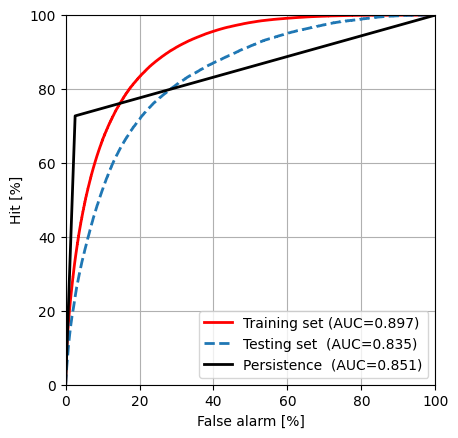

In [ ]:
plot_roc(f"Training set (AUC={auc_train:.3f})", y_train.flatten(), pred_y_train.flatten(), color="red")
plot_roc(f"Testing set  (AUC={auc_test:.3f})", y_test.flatten(), pred_y_test.flatten(), linestyle='--')
plot_roc(f"Persistence  (AUC={auc_persistence:.3f})", y_test.flatten(), test_data_y_lt0.flatten(), linestyle='-', color="black")
plt.legend(loc='lower right');

### Reliability diagram

In [ ]:
def reliability_curve(y, y_pred, bin_size=0.1, count_pred_per_bin=100):
  y = np.array(y)
  y_pred = np.array(y_pred)
  bins = np.arange(0, 1+bin_size, bin_size)
  bin_centers = [(b1 + b2) / 2 for b1, b2 in zip(bins[:-1], bins[1:])]
  prop_positive = []
  bin_center_ax = []
  no_pred_per_bin = []
  for b1, b2, bc in zip(bins[:-1], bins[1:], bin_centers):
    in_bin = np.logical_and(y_pred >= b1, y_pred < b2)
    no_predictions_per_bin = np.sum(in_bin)
    no_positive_per_bin = np.sum(y[in_bin])
    if no_predictions_per_bin > count_pred_per_bin:
      prop_pos = round(no_positive_per_bin/no_predictions_per_bin, 3)
      prop_positive.append(prop_pos)
      bin_center_ax.append(round(bc, 3))
      no_pred_per_bin.append(no_predictions_per_bin)
    else:
      continue
  return bin_center_ax, prop_positive, no_pred_per_bin

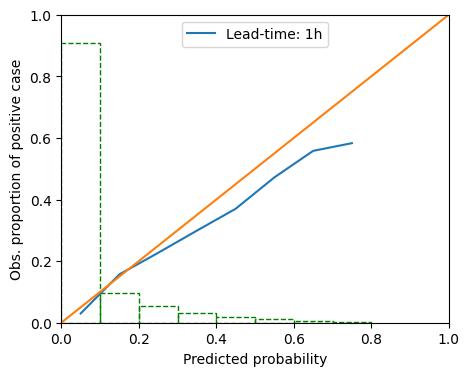

In [ ]:
prob_pred, prob_true, no_pred_per_bin = reliability_curve(y_test.flatten(), pred_y_test.flatten())
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, label=f"Lead-time: 1h")

plt.xlabel("Predicted probability")
plt.ylabel("Obs. proportion of positive case")

no_pred_per_bin = [i/(1.1*np.max(no_pred_per_bin)) for i in no_pred_per_bin]
plt.plot(np.arange(0,1.2,0.2), np.arange(0,1.2,0.2))
plt.bar(prob_pred, no_pred_per_bin, width=0.1, linestyle="--", fill=False, edgecolor="green")

plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='upper center')
plt.show()

## Plotting

In [ ]:
idx = []
for i in range(y_test.shape[0]):
    idx.append(np.mean(y_test[i]))
idx_max = np.argmax(idx)

In [ ]:
index_display = idx_max

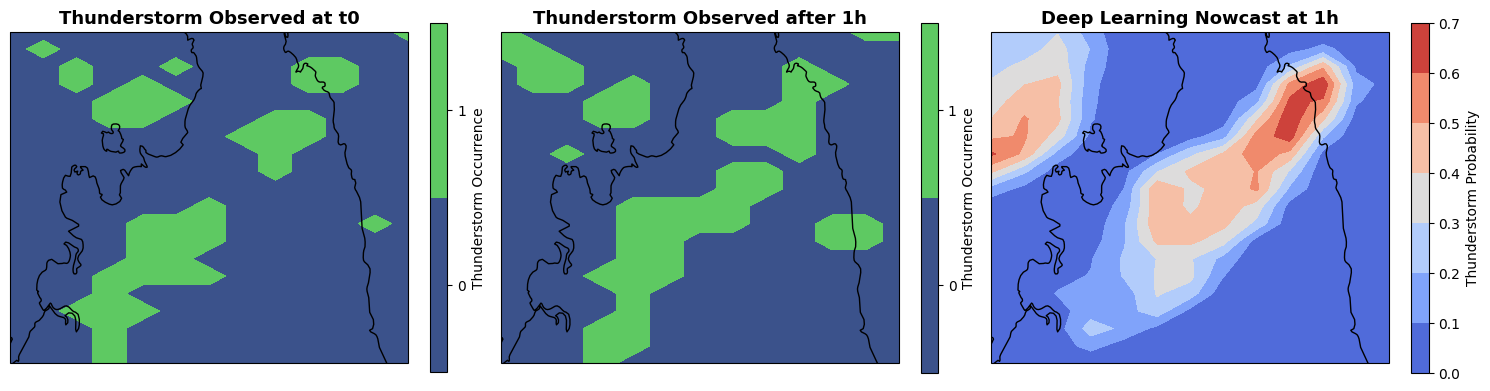

In [ ]:
# Parameters
extent = (47.5, 50.5, -15, -12.5)
lon_min, lon_max, lat_min, lat_max = extent
n_rows, n_cols = 20, 13  # Number of latitude points and longitude points

# Create linearly spaced values for latitudes and longitudes and create meshgrids
latitudes = np.linspace(lat_min, lat_max, n_rows)
longitudes = np.linspace(lon_min, lon_max, n_cols)
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Index for data to display
index_display = idx_max
to_display = [
    test_data_y_lt0[index_display],  # Add new data here
    y_test[index_display],
    pred_y_test.reshape(len(y_test), n_rows, n_cols)[index_display],
]
titles = ["Thunderstorm Observed at t0", "Thunderstorm Observed after 1h", "Deep Learning Nowcast at 1h"]

colormaps = ["viridis", "viridis", "coolwarm"]  # Add colormap for the new subplot

# Create three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through the axes to plot each subplot
for i, ax in enumerate(axes):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, edgecolor='gray')
    ax.tick_params(bottom=True, left=True, top=False, right=False)

    # Plot data with appropriate colormap
    if i == 0 or i == 1:  # True Binary target
        contour = ax.contourf(
            lon_grid, lat_grid, to_display[i], transform=ccrs.PlateCarree(), cmap=colormaps[i], levels=[-0.5, 0.5, 1.5]
        )
        # Add discrete colorbar
        cbar = fig.colorbar(contour, ax=ax, orientation='vertical', fraction=0.04, pad=0.05, ticks=[0, 1])
        cbar.set_label("Thunderstorm Occurrence")
        cbar.ax.set_yticklabels(["0", "1"])

    else:  # Continuous or additional data target
        contour = ax.contourf(
            lon_grid, lat_grid, to_display[i], transform=ccrs.PlateCarree(), cmap=colormaps[i]
        )
        # Add continuous colorbar
        cbar = fig.colorbar(contour, ax=ax, orientation='vertical', fraction=0.04, pad=0.05)
        cbar.set_label("Probability" if i == 1 else "Thunderstorm Probability")

    ax.set_title(titles[i], fontsize=13, fontweight='bold')

# Adjust layout and display
plt.tight_layout()
plt.show()
